## Libraries import

In [2]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

## Helper Functions

We will define a helper function, ```show_data``` to plot the images individually from the Fashion Dataset. The raw images from the dataset which can also be resized, are 28px height and 28px wide.

In [9]:
IMAGE_SIZE = 28

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## Dataset Handling

During this project we'll be working with the MNIST Fashion dataset, a well know dataset which happens to come together as a toy example within the pytorch library.

The Fashion-MNIST dataset is proposed as a more challenging replacement dataset for the MNIST dataset. It is a dataset comprised of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more.

In [10]:
# transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor()])

In [14]:
train_dataset = dsets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
validation_dataset = dsets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

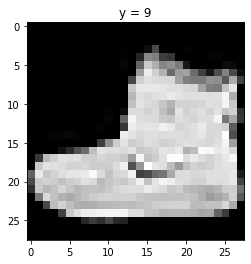

In [15]:
show_data(train_dataset[0])

## Building the Model

One of the hardest parts of designing the model is determining the inputs of the last linear layer.

![2 Layer CNN](img/2layersCNN.png)


We'll create a 2-layer CNN with a Max Pool activation function piped to the convolution result. Since we don´t want to loose the images edges, we'll add padding to the images before the convolution takes place. During the whole project we'll be working with square matrices where m=n (rows are equal to columns). We will refer to the matrix dimension as M, where in this particular case M=28 for the raw images.

### Convolution parameters

- ```kernel = 5```
- ```padding = 2```
- ```stride = 1```
- ```dilation = 1```

Given this parameters, the new matrix dimension after the convolution process is:
M_new = M + 2 * p - k + 1
M_new = M

where:
- p: padding
- k: kernel size
- M: matrix size

### MaxPool Activation parameters
For the MaxPool activation, stride is by default the size of the kernel. Parameters are:

- ```kernel = 2```
- ```padding = 0```
- ```stride = 2```
- ```dilation = 1```

Given this parameters, the new matrix dimension after the Max Pool activation are:

M_new = (M - k)/s + 1
M_new = (M - 2)/2 + 1
M_new = M/2

- After the first convolution, the output matrices have a dimension of 28x28 px.
- The dimension of the matrices after the Max Pool activation are 14x14 px.
- The resultant matrices after the second convolution, with the same kernel and padding as the fist one, are 14x14 px.
- Finally after the last Max Pool activation, the resultant matrices have a dimension of 7x7 px.

In [59]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 7 * 7, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        # Flatten the matrices
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [60]:
model = CNN(out_1=16, out_2=32)

## Determining Optimizer and Data Loader

In [61]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

## Training the Model

In [62]:
# Train the model

n_epochs=6
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

1568 1568


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x1568 and 800x10)

## Analyzing the Results

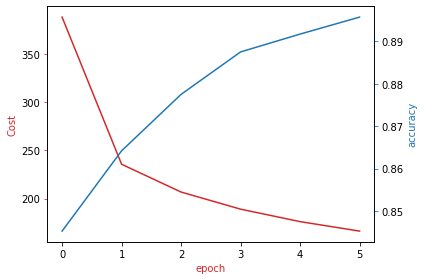

In [16]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## Checking Classifications

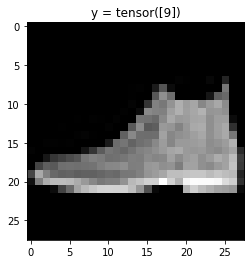

yhat:  tensor([9])


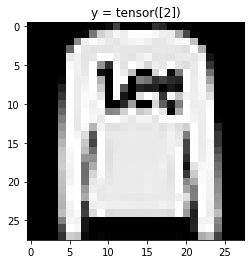

yhat:  tensor([2])


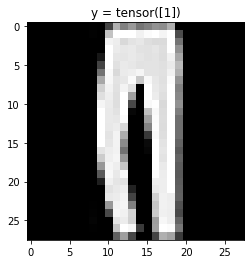

yhat:  tensor([1])


In [18]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    show_data((x, y))
    plt.show()
    print("yhat: ",yhat)
    count += 1
    if count >= 3:
        break  